In [1]:
import pickle
import json
import os
import math
!pip install unidecode
import unidecode
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter
from math import ceil
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 1.7 MB/s eta 0:00:00


In [2]:
# HuggingFace library to train a tokenizer
from tokenizers import Tokenizer, normalizers
from tokenizers.models import WordPiece
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Cambiar path para correr desde otro lado**

In [4]:
import os
base_path = '/content/drive/MyDrive/openalex-institution-parsing/'


### Combining the training data from 001 notebook and artificial data

In [5]:
# All training samples that have less than 50 different version of the affiliation text
# ---- Created in previous notebookaffili
#lower_than = pd.read_parquet("lower_than_50.parquet")
lower_than = pd.read_parquet(f"{base_path}V2/002_Model/lower_than_50.parquet")


# All training samples that have more than 50 different version of the affiliation text
# ---- Created in previous notebook
#more_than = pd.read_parquet("more_than_50.parquet")
more_than = pd.read_parquet(f'{base_path}/V2/002_Model/more_than_50.parquet')

print(lower_than.shape)
print(more_than.shape)

(7950, 2)
(12659, 2)


In [6]:
full_affs_data = pd.concat([more_than, lower_than],
                           axis=0).reset_index(drop=True)

In [7]:
full_affs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20609 entries, 0 to 20608
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   original_affiliation  20609 non-null  object
 1   affiliation_id        20609 non-null  object
dtypes: object(2)
memory usage: 322.1+ KB


In [8]:
full_affs_data.head()

,original_affiliation,affiliation_id
0,Dep of Materials Science and Engineering Argen...,4210131417
1,Argentine Atlantis University Dept. of English...,4210131417
2,Dept. of Materials Science and Engineering Arg...,4210131417
3,Argentine Atlantis University Dept of Applied ...,4210131417
4,Argentine Atlantis University College of Scien...,4210131417


In [9]:
##guardamos como parquet
full_affs_data.to_parquet(f'{base_path}V2/002_Model/full_affs_data.parquet')

In [10]:
full_affs_data.shape

(20609, 2)

In [11]:
full_affs_data['text_len'] = full_affs_data['original_affiliation'].apply(len)

In [12]:
full_affs_data = full_affs_data[full_affs_data['text_len'] < 500][['original_affiliation','affiliation_id']].copy()

In [13]:
full_affs_data.shape

(20609, 2)

In [14]:
full_affs_data['affiliation_id'] = full_affs_data['affiliation_id'].astype('str')

In [15]:
full_affs_data.head(n=3)

,original_affiliation,affiliation_id
0,Dep of Materials Science and Engineering Argen...,4210131417
1,Argentine Atlantis University Dept. of English...,4210131417
2,Dept. of Materials Science and Engineering Arg...,4210131417


In [16]:
full_affs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20609 entries, 0 to 20608
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   original_affiliation  20609 non-null  object
 1   affiliation_id        20609 non-null  object
dtypes: object(2)
memory usage: 322.1+ KB


### Processing and splitting the data

In [17]:
##nueva función para preprocesar con todo el dataset

import re # Import the 're' module for regular expressions

def preprocess_affiliation_text(text):
    # Normalización de caracteres
    text = unidecode.unidecode(text)
    # Convertir a minúsculas
    text = text.lower()
    # Remover caracteres especiales (si es necesario)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Aplicar el preprocesamiento a los datos de entrenamiento, validación y prueba
full_affs_data['processed_text'] = full_affs_data['original_affiliation'].apply(preprocess_affiliation_text)

##antes estaba la sig linea
##full_affs_data['processed_text'] = full_affs_data['original_affiliation'].apply(unidecode.unidecode)

In [18]:
full_affs_data.head()

,original_affiliation,affiliation_id,processed_text
0,Dep of Materials Science and Engineering Argen...,4210131417,dep of materials science and engineering argen...
1,Argentine Atlantis University Dept. of English...,4210131417,argentine atlantis university dept of english ...
2,Dept. of Materials Science and Engineering Arg...,4210131417,dept of materials science and engineering arge...
3,Argentine Atlantis University Dept of Applied ...,4210131417,argentine atlantis university dept of applied ...
4,Argentine Atlantis University College of Scien...,4210131417,argentine atlantis university college of scien...


In [19]:
train_data, val_data = train_test_split(full_affs_data, train_size=0.80, random_state=1)
train_data = train_data.reset_index(drop=True).copy()
val_data = val_data.reset_index(drop=True).copy()

In [20]:
train_data.shape

(16487, 3)

In [21]:
val_data.shape

(4122, 3)

In [22]:
affs_list_train = train_data['processed_text'].tolist()
affs_list_val = val_data['processed_text'].tolist()
affs_list_val[:5]

['national university of misiones sch of education',
 'universidad nacional de la patagonia san juan bosco sch of engineering trelew argentina',
 'college of design universidad del museo social argentino buenos aires',
 'universidad catolica argentina buenos aires buenos aires fd',
 'dep of obstetrics and gynecology hospital el cruce buenos aires']

In [23]:
try:
    os.system("rm {base_path}V2/002_Model/aff_text.txt")
    print("Done")
except:
    pass

Done


In [24]:
# save the affiliation text that will be used to train a tokenizer
#with open("aff_text.txt", "w") as f:
base_path = '/content/drive/MyDrive/openalex-institution-parsing/'
with open(f"{base_path}V2/002_Model/aff_text.txt", "w") as f: # Added 'w' to open in write mode
    for aff in affs_list_train:
        f.write(f"{aff}\n")

In [25]:
try:
    os.system("rm {base_path}V2/002_Model/basic_model_tokenizer")
    print("Done")
except:
    pass

Done


In [26]:
#full_affs_data[['processed_text','affiliation_id']].to_parquet("full_affs_data_processed.parquet")
full_affs_data[['processed_text','affiliation_id']].to_parquet(f"{base_path}V2/002_Model/full_affs_data_processed.parquet")


### Creating the tokenizer for the basic model

In [27]:
wordpiece_tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))

# NFD Unicode, lowercase, and getting rid of accents (to make sure text is as readable as possible)
wordpiece_tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase(), StripAccents()])

# Splitting on whitespace
wordpiece_tokenizer.pre_tokenizer = Whitespace()

# Training a tokenizer on the training dataset
trainer = WordPieceTrainer(vocab_size=3816, special_tokens=["[UNK]"])
#files = ["aff_text.txt"]
files = [f"{base_path}V2/002_Model/aff_text.txt"]

wordpiece_tokenizer.train(files, trainer)

#wordpiece_tokenizer.save("basic_model_tokenizer")
wordpiece_tokenizer.save(f"{base_path}V2/002_Model/basic_model_tokenizer")

In [28]:
print(wordpiece_tokenizer)

Tokenizer(version="1.0", truncation=None, padding=None, added_tokens=[{"id":0, "content":"[UNK]", "single_word":False, "lstrip":False, "rstrip":False, ...}], normalizer=Sequence(normalizers=[NFD(), Lowercase(), StripAccents()]), pre_tokenizer=Whitespace(), post_processor=None, decoder=None, model=WordPiece(unk_token="[UNK]", continuing_subword_prefix="##", max_input_chars_per_word=100, vocab={"[UNK]":0, "1":1, "2":2, "a":3, "b":4, ...}))


### Further processing of data with tokenizer

In [29]:
def max_len_and_pad(tok_sent):
    """
    Truncates sequences with length higher than max_len and also pads the sequence
    with zeroes up to the max_len.
    """
    max_len = 128
    tok_sent = tok_sent[:max_len]
    tok_sent = tok_sent + [0]*(max_len - len(tok_sent))
    return tok_sent

def create_affiliation_vocab(x):
    """
    Checks if affiliation is in vocab and if not, adds to the vocab.
    """
    if x not in affiliation_vocab.keys():
        affiliation_vocab[x]=len(affiliation_vocab)
    return [affiliation_vocab[x]]




In [30]:
# initializing an empty affiliation vocab
affiliation_vocab = {}

# tokenizing the training dataset
tokenized_output = []
for i in affs_list_train:
    tokenized_output.append(wordpiece_tokenizer.encode(i).ids)

train_data['original_affiliation_tok'] = tokenized_output
train_data['original_affiliation_tok'].head(1)

,original_affiliation_tok
0,"[186, 1613, 59, 1621, 27, 1623, 190, 142, 181,..."


In [31]:
# tokenizing the validation dataset
tokenized_output = []
for i in affs_list_val:
    tokenized_output.append(wordpiece_tokenizer.encode(i).ids)

val_data['original_affiliation_tok'] = tokenized_output

In [32]:
# applying max length cutoff and padding
train_data['original_affiliation_model_input'] = train_data['original_affiliation_tok'].apply(max_len_and_pad)
val_data['original_affiliation_model_input'] = val_data['original_affiliation_tok'].apply(max_len_and_pad)

In [33]:
train_data['original_affiliation_tok'].apply(max_len_and_pad).head(1)

,original_affiliation_tok
0,"[186, 1613, 59, 1621, 27, 1623, 190, 142, 181,..."


In [34]:
val_data['original_affiliation_tok'].apply(max_len_and_pad).head(1)

,original_affiliation_tok
0,"[173, 155, 65, 496, 184, 65, 926, 0, 0, 0, 0, ..."


In [35]:
# creating the label affiliation vocab
train_data['label'] = train_data['affiliation_id'].apply(lambda x: create_affiliation_vocab(x))

In [36]:
train_data['affiliation_id'].apply(lambda x: create_affiliation_vocab(x)).head(3)

,affiliation_id
0,[0]
1,[1]
2,[2]


In [37]:
train_data.shape

(16487, 6)

In [38]:
len(affiliation_vocab)

331

In [39]:
val_data['label'] = val_data['affiliation_id'].apply(lambda x: [affiliation_vocab.get(x)])

In [40]:
val_data['affiliation_id'].apply(lambda x: [affiliation_vocab.get(x)]).head(3)

,affiliation_id
0,[17]
1,[173]
2,[141]


In [41]:
val_data.shape

(4122, 6)

In [42]:
dict(list(affiliation_vocab.items())[0:10])

{'4210158246': 0,
 '4210131338': 1,
 '4210113115': 2,
 '4210104034': 3,
 '4210156592': 4,
 '4210103251': 5,
 '4210133753': 6,
 '4210153210': 7,
 '297007282': 8,
 '4210105563': 9}

In [43]:
#train_data.to_parquet("train_data.parquet")
#val_data.to_parquet("val_data.parquet")

train_data.to_parquet(f"{base_path}V2/002_Model/training_data/train_data.parquet")
val_data.to_parquet(f"{base_path}V2/002_Model/training_data/val_data.parquet")

In [44]:
# saving the affiliation vocab
with open(f"{base_path}Crudos/institution_tagger_v2_artifacts/affiliation_vocab_argentina.pkl","wb") as f:
    pickle.dump(affiliation_vocab, f)


with open(f"{base_path}Crudos/institution_tagger_v2_artifacts/affiliation_vocab_argentina.pkl","rb") as f:
    affiliation_vocab = pickle.load(f)


###agrego "-1" para evitar futuros errores
affiliation_vocab[-1]=len(affiliation_vocab)
affiliation_vocab

with open(f"{base_path}Crudos/institution_tagger_v2_artifacts/affiliation_vocab_argentina.pkl","wb") as f:
    pickle.dump(affiliation_vocab, f)


In [45]:
len(affiliation_vocab)

332

### Creating TFRecords from the training and validation datasets

In [46]:
train_data = pd.read_parquet(f"{base_path}V2/002_Model/training_data/train_data.parquet")

In [47]:
val_data = pd.read_parquet(f"{base_path}V2/002_Model/training_data/val_data.parquet")

In [48]:
# saving the affiliation vocab
with open(f"{base_path}Crudos/institution_tagger_v2_artifacts/affiliation_vocab_argentina.pkl","rb") as f:
    affiliation_vocab = pickle.load(f)

In [49]:
def create_tfrecords_dataset(data, iter_num, dataset_type='train'):
    """
    Creates a TF Dataset that can then be saved to a file to make it faster to read
    data during training and allow for transferring of data between compute instances.
    """
    ds = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(data['original_affiliation_model_input'].to_list()),
                              tf.data.Dataset.from_tensor_slices(data['label'].to_list())))

    serialized_features_dataset = ds.map(tf_serialize_example)

    filename = f"{base_path}V2/002_Model/training_data/{dataset_type}/{str(iter_num).zfill(4)}.tfrecord"
    writer = tf.data.experimental.TFRecordWriter(filename)
    writer.write(serialized_features_dataset)

In [50]:
def tf_serialize_example(f0, f1):
    """
    Serialization function.
    """
    tf_string = tf.py_function(serialize_example, (f0, f1), tf.string)
    return tf.reshape(tf_string, ())

In [51]:
def serialize_example(features, label):
    """
    Takes in features and outputs them to a serialized string that can be written to
    a file using the TFRecord Writer.
    """
    features_list = tf.train.Int64List(value=features.numpy().tolist())
    label_list = tf.train.Int64List(value=label.numpy().tolist())

    features_feature = tf.train.Feature(int64_list = features_list)
    label_feature = tf.train.Feature(int64_list = label_list)

    features_for_example = {
        'features': features_feature,
        'label': label_feature
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=features_for_example))

    return example_proto.SerializeToString()

In [52]:
# Making sure data is in the correct format before going into TFRecord
train_data['original_affiliation_model_input'] = train_data['original_affiliation_model_input'] \
.apply(lambda x: np.asarray(x, dtype=np.int64))

val_data['original_affiliation_model_input'] = val_data['original_affiliation_model_input'] \
.apply(lambda x: np.asarray(x, dtype=np.int64))

In [53]:
os.system(f"mkdir -p {base_path}V2/002_Model/training_data/train/")
os.system(f"mkdir -p {base_path}V2/002_Model/training_data/val/")
print("Done")

Done


#### Creating the Train Dataset

In [54]:
%%time
for i in range(ceil(train_data.shape[0]/500000)):
    print(i)
    low = i*500000
    high = (i+1)*500000
    create_tfrecords_dataset(train_data.iloc[low:high,:], i, 'train')

0


Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`


CPU times: user 7.3 s, sys: 709 ms, total: 8.01 s
Wall time: 14.2 s


#### Creating the Validation Dataset

In [55]:
%%time
for i in range(ceil(val_data.shape[0]/60000)):
    print(i)
    low = i*60000
    high = (i+1)*60000
    create_tfrecords_dataset(val_data.iloc[low:high,:], i, 'val')

0
CPU times: user 1.79 s, sys: 89.9 ms, total: 1.88 s
Wall time: 2.9 s


In [56]:
train_data.head(n=8)

,original_affiliation,affiliation_id,processed_text,original_affiliation_tok,original_affiliation_model_input,label
0,Centro Diocesano de Estudio y Reflexion Mar de...,4210158246,centro diocesano de estudio y reflexion mar de...,"[186, 1613, 59, 1621, 27, 1623, 190, 142, 181,...","[186, 1613, 59, 1621, 27, 1623, 190, 142, 181,...",[0]
1,Juan Agustin Maza University Dept of Psycholog...,4210131338,juan agustin maza university dept of psycholog...,"[377, 1028, 1026, 155, 105, 65, 677, 248]","[377, 1028, 1026, 155, 105, 65, 677, 248, 0, 0...",[1]
2,Administracion Nacional de Laboratorios e Inst...,4210113115,administracion nacional de laboratorios e inst...,"[957, 150, 59, 1344, 7, 1325, 59, 368, 71, 72]","[957, 150, 59, 1344, 7, 1325, 59, 368, 71, 72,...",[2]
3,Astronomical Observatory of Cordoba Argentina,4210104034,astronomical observatory of cordoba argentina,"[1256, 844, 65, 153, 76]","[1256, 844, 65, 153, 76, 0, 0, 0, 0, 0, 0, 0, ...",[3]
4,Instituto de Botanica Darwinion Dep of Industr...,4210156592,instituto de botanica darwinion dep of industr...,"[124, 59, 1944, 1953, 79, 65, 580, 744, 148, 1...","[124, 59, 1944, 1953, 79, 65, 580, 744, 148, 1...",[4]
5,"Dept of Cardiology Hospital Ramos Mejia, Bueno...",4210103251,dept of cardiology hospital ramos mejia buenos...,"[105, 65, 694, 132, 1075, 1072, 71, 72, 76]","[105, 65, 694, 132, 1075, 1072, 71, 72, 76, 0,...",[5]
6,Instituto Nacional de Limnologia,4210133753,instituto nacional de limnologia,"[124, 150, 59, 1783]","[124, 150, 59, 1783, 0, 0, 0, 0, 0, 0, 0, 0, 0...",[6]
7,"Universidad Nacional de Formosa, Formosa",4210153210,universidad nacional de formosa formosa,"[123, 150, 59, 1057, 1057]","[123, 150, 59, 1057, 1057, 0, 0, 0, 0, 0, 0, 0...",[7]


In [57]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16487 entries, 0 to 16486
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   original_affiliation              16487 non-null  object
 1   affiliation_id                    16487 non-null  object
 2   processed_text                    16487 non-null  object
 3   original_affiliation_tok          16487 non-null  object
 4   original_affiliation_model_input  16487 non-null  object
 5   label                             16487 non-null  object
dtypes: object(6)
memory usage: 773.0+ KB


In [58]:
val_data.head(n=3)

,original_affiliation,affiliation_id,processed_text,original_affiliation_tok,original_affiliation_model_input,label
0,National University of Misiones Sch of Education,17994240,national university of misiones sch of education,"[173, 155, 65, 496, 184, 65, 926]","[173, 155, 65, 496, 184, 65, 926, 0, 0, 0, 0, ...",[17]
1,Universidad Nacional de la Patagonia San Juan ...,3129709771,universidad nacional de la patagonia san juan ...,"[123, 150, 59, 136, 901, 125, 377, 1610, 184, ...","[123, 150, 59, 136, 901, 125, 377, 1610, 184, ...",[173]
2,College of Design Universidad del Museo Social...,4210117969,college of design universidad del museo social...,"[376, 65, 968, 123, 142, 2159, 408, 731, 71, 72]","[376, 65, 968, 123, 142, 2159, 408, 731, 71, 7...",[141]


In [59]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4122 entries, 0 to 4121
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   original_affiliation              4122 non-null   object
 1   affiliation_id                    4122 non-null   object
 2   processed_text                    4122 non-null   object
 3   original_affiliation_tok          4122 non-null   object
 4   original_affiliation_model_input  4122 non-null   object
 5   label                             4122 non-null   object
dtypes: object(6)
memory usage: 193.3+ KB


In [60]:
def get_dataset(path, data_type='train'):
    """
    Takes in a path to the TFRecords and returns a TF Dataset to be used for training.
    """
    tfrecords = [f"{path}{data_type}/{x}" for x in os.listdir(f"{path}{data_type}/") if x.endswith('tfrecord')]
    tfrecords.sort()

    raw_dataset = tf.data.TFRecordDataset(tfrecords, num_parallel_reads=AUTO)
    parsed_dataset = raw_dataset.map(_parse_function, num_parallel_calls=AUTO)

    parsed_dataset = parsed_dataset.apply(tf.data.experimental.dense_to_ragged_batch(512,drop_remainder=True))
    return parsed_dataset

In [61]:
def _parse_function(example_proto):
    """
    Parses the TFRecord file.
    """
    feature_description = {
        'features': tf.io.FixedLenFeature((128,), tf.int64),
        'label': tf.io.FixedLenFeature((1,), tf.int64)
    }

    example = tf.io.parse_single_example(example_proto, feature_description)

    features = example['features']
    label = example['label'][0]

    return features, label

### Loading the Data

In [62]:
train_data_path = f"{base_path}V2/002_Model/training_data/"
AUTO = tf.data.experimental.AUTOTUNE
training_data = get_dataset(train_data_path, data_type='train')
validation_data = get_dataset(train_data_path, data_type='val')

Instructions for updating:
Use `tf.data.Dataset.ragged_batch` instead.


In [63]:
val_data.isna().sum()

,0
original_affiliation,0
affiliation_id,0
processed_text,0
original_affiliation_tok,0
original_affiliation_model_input,0
label,0


In [64]:
train_data.isna().sum()

,0
original_affiliation,0
affiliation_id,0
processed_text,0
original_affiliation_tok,0
original_affiliation_model_input,0
label,0


### Load Vocab

In [65]:
# Loading the affiliation (target) vocab
with open(f"{base_path}Crudos/institution_tagger_v2_artifacts/affiliation_vocab_argentina.pkl","rb") as f:
    affiliation_vocab_id = pickle.load(f)

In [66]:
affiliation_vocab_id = {int(i):int(j) for i,j in affiliation_vocab_id.items()}
print(affiliation_vocab_id)
inverse_affiliation_vocab_id = {(i):(j) for j,i in affiliation_vocab_id.items()}
print(inverse_affiliation_vocab_id)

{4210158246: 0, 4210131338: 1, 4210113115: 2, 4210104034: 3, 4210156592: 4, 4210103251: 5, 4210133753: 6, 4210153210: 7, 297007282: 8, 4210105563: 9, 4210089903: 10, 4210131024: 11, 4210140555: 12, 4210088229: 13, 4210131002: 14, 4210166344: 15, 4210142366: 16, 17994240: 17, 4210112996: 18, 4210138750: 19, 4210161629: 20, 4210093154: 21, 4210118619: 22, 4210110275: 23, 2801749607: 24, 3131897482: 25, 4210098917: 26, 4210111270: 27, 4210130110: 28, 4210100158: 29, 4210106546: 30, 4210144271: 31, 4210145890: 32, 2802359038: 33, 4210146220: 34, 128590013: 35, 41147313: 36, 4210154562: 37, 4210119967: 38, 4210093368: 39, 4210138160: 40, 130054616: 41, 151201029: 42, 3129902936: 43, 4210152379: 44, 4210099566: 45, 2799873577: 46, 4210164372: 47, 4210125970: 48, 4210123918: 49, 4210113384: 50, 4210157027: 51, 4210134895: 52, 4210107757: 53, 4210160985: 54, 4210105545: 55, 4210139031: 56, 4210109749: 57, 4210096988: 58, 4210143717: 59, 272649133: 60, 127019355: 61, 174689663: 62, 4210102755: 

### Creating Model

In [67]:
# Hyperparameters to tune
emb_size = 256
max_len = 128
num_layers = 3  ## se cambió de 6 a 3
num_heads = 8
dense_1 = 2048
dense_2 = 1024
learn_rate = 0.01 ## la cambié de 0.0004 a 0.001

In [68]:
def scheduler(epoch, curr_lr):
    """
    Setting up a exponentially decaying learning rate.
    """
    rampup_epochs = 2
    exp_decay = 0.17
    def lr(epoch, beg_lr, rampup_epochs, exp_decay):
        if epoch < rampup_epochs:
            return beg_lr
        else:
            return beg_lr * math.exp(-exp_decay * epoch)
    return lr(epoch, start_lr, rampup_epochs, exp_decay)

In [69]:
# Allow for use of multiple GPUs
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    # Model Inputs
    tokenized_aff_string_ids = tf.keras.layers.Input((128,), dtype=tf.int64, name='tokenized_aff_string_input')

    # Embedding Layers
    tokenized_aff_string_emb_layer = tf.keras.layers.Embedding(input_dim=3816,
                                                               output_dim=int(emb_size),
                                                               mask_zero=True,
                                                               trainable=True,
                                                               name="tokenized_aff_string_embedding")

    tokenized_aff_string_embs = tokenized_aff_string_emb_layer(tokenized_aff_string_ids)

    # First dense layer
    dense_output = tf.keras.layers.Dense(int(dense_1), activation='relu',
                                             kernel_regularizer='L2', name="dense_1")(tokenized_aff_string_embs)
    dense_output = tf.keras.layers.Dropout(0.20, name="dropout_1")(dense_output)
    dense_output = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="layer_norm_1")(dense_output)
    pooled_output = tf.keras.layers.GlobalAveragePooling1D()(dense_output)

    # Second dense layer
    dense_output = tf.keras.layers.Dense(int(dense_2), activation='relu',
                                             kernel_regularizer='L2', name="dense_2")(pooled_output)
    dense_output = tf.keras.layers.Dropout(0.20, name="dropout_2")(dense_output)
    dense_output = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="layer_norm_2")(dense_output)

    # Last dense layer
    final_output = tf.keras.layers.Dense(len(affiliation_vocab_id), activation='softmax', name='cls')(dense_output)

    model = tf.keras.Model(inputs=tokenized_aff_string_ids, outputs=final_output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate, beta_1=0.9,
                                                     beta_2=0.99),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    curr_date = datetime.now().strftime("%Y%m%d")

    filepath_1 = f"./models/{curr_date}_{dense_1}d1_{dense_2}d2/" \


    filepath = filepath_1 + "model_epoch{epoch:02d}ckpt.keras"

    # Adding in checkpointing
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss',
                                                          verbose=0, save_best_only=False,
                                                          save_weights_only=False, mode='auto',
                                                          save_freq='epoch')

    # Adding in early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4)

    start_lr = float(learn_rate)

    # Adding in a learning rate schedule to decrease learning rate in later epochs
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

    callbacks = [model_checkpoint, early_stopping, lr_schedule]


In [70]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tokenized_aff_string_inp… │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tokenized_aff_string_emb… │ (None, 128, 256)       │        976,896 │ tokenized_aff_string_… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128, 2048)      │        526,336 │ tokenized_aff_string_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 2048)      │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm_1              │ (None, 128, 2048)      │          4,096 │ dropout_1[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 128)            │              0 │ tokenized_aff_string_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 2048)           │              0 │ layer_norm_1[0][0],    │
│ (GlobalAveragePooling1D)  │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1024)           │      2,098,176 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1024)           │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm_2              │ (None, 1024)           │          2,048 │ dropout_2[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cls (Dense)               │ (None, 332)            │        340,300 │ layer_norm_2[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,947,852 (15.06 MB)

 Trainable params: 3,947,852 (15.06 MB)

 Non-trainable params: 0 (0.00 B)

### Training the Model

In [71]:
"""Ver keras tuner para grid search
from sklearn.model_selection import GridSearchCV

param_grid = dict(epochs=[5,10,20,30])
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy')
grid_result = grid.fit(training_data, validation_data, callbacks=callbacks)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))"""

'Ver keras tuner para grid search\nfrom sklearn.model_selection import GridSearchCV\n\nparam_grid = dict(epochs=[5,10,20,30])\ngrid = GridSearchCV(estimator=model, param_grid=param_grid,scoring=\'accuracy\')\ngrid_result = grid.fit(training_data, validation_data, callbacks=callbacks)\n\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))'

The ***batch size*** in iterative gradient descent is the number of patterns shown to the network before the weights are updated. It is also an optimization in the training of the network, defining how many patterns to read at a time and keep in memory.

The ***number of epochs*** is the number of times the entire training dataset is shown to the network during training. Some networks are sensitive to the batch size, such as LSTM recurrent neural networks and Convolutional Neural Networks.

In [72]:
history = model.fit(training_data, epochs=20, validation_data=validation_data, verbose=1, callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/20
     32/Unknown 12s 227ms/step - loss: 19.3096 - sparse_categorical_accuracy: 0.1801

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - loss: 19.1080 - sparse_categorical_accuracy: 0.1850 - val_loss: 4.4385 - val_sparse_categorical_accuracy: 0.6289 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - loss: 4.3907 - sparse_categorical_accuracy: 0.7777 - val_loss: 2.8955 - val_sparse_categorical_accuracy: 0.8175 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.007117703227626096.
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - loss: 2.5837 - sparse_categorical_accuracy: 0.9278 - val_loss: 1.5155 - val_sparse_categorical_accuracy: 0.8622 - learning_rate: 0.0071

Epoch 4: LearningRateScheduler setting learning rate to 0.006004955788122659.
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - loss: 1.5147 - sparse_categorical_accuracy: 0.9591 - val_loss: 1.1756 - val_sparse_categorical_accuracy: 0.8626 - learning_rate: 0.0060

Epoch 5: LearningRateSched

In [73]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tokenized_aff_string_inp… │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tokenized_aff_string_emb… │ (None, 128, 256)       │        976,896 │ tokenized_aff_string_… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128, 2048)      │        526,336 │ tokenized_aff_string_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 2048)      │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm_1              │ (None, 128, 2048)      │          4,096 │ dropout_1[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 128)            │              0 │ tokenized_aff_string_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 2048)           │              0 │ layer_norm_1[0][0],    │
│ (GlobalAveragePooling1D)  │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1024)           │      2,098,176 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1024)           │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm_2              │ (None, 1024)           │          2,048 │ dropout_2[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cls (Dense)               │ (None, 332)            │        340,300 │ layer_norm_2[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,843,558 (45.18 MB)

 Trainable params: 3,947,852 (15.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,895,706 (30.12 MB)

In [74]:
json.dump(str(history.history), open(f"{filepath_1}_25EPOCHS_HISTORY.json", 'w+'))

model.save(f'{base_path}V2/002_Model/Result_basic_model/modelo_basico0411.keras')
# %%
print('FINALIZADO OK')

FINALIZADO OK


In [75]:
model.export(f'{base_path}V2/002_Model/Result_basic_model/modelo_basico_export')


Saved artifact at '/content/drive/MyDrive/openalex-institution-parsing/V2/002_Model/Result_basic_model/modelo_basico_export'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128), dtype=tf.int64, name='tokenized_aff_string_input')
Output Type:
  TensorSpec(shape=(None, 332), dtype=tf.float32, name=None)
Captures:
  132416504150704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132416504593600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132416504592896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132416504296400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132416504299216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132416504388016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132416504382560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132416504387488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132416504390128: TensorSpec(shape=(), dtype=tf.resource, nam

In [76]:
# para guardar archivo del modelo (codigo original no genera los archivos que se levantan en la siguiente notebook)

import os
import tensorflow as tf

# Definir el directorio en la carpeta actual donde deseas guardar el modelo
saved_model_dir = f'{base_path}V2/002_Model/Result_basic_model/basic_model/'

# Crear el directorio si no existe
os.makedirs(saved_model_dir, exist_ok=True)

# Guardar el modelo en formato SavedModel usando tf.saved_model.save()
tf.saved_model.save(model, saved_model_dir)
print(f"Modelo guardado en {saved_model_dir}")

Modelo guardado en /content/drive/MyDrive/openalex-institution-parsing/V2/002_Model/Result_basic_model/basic_model/


In [77]:
## opciones para guardar el modelo
##https://medium.com/swlh/saving-and-loading-of-keras-sequential-and-functional-models-73ce704561f4

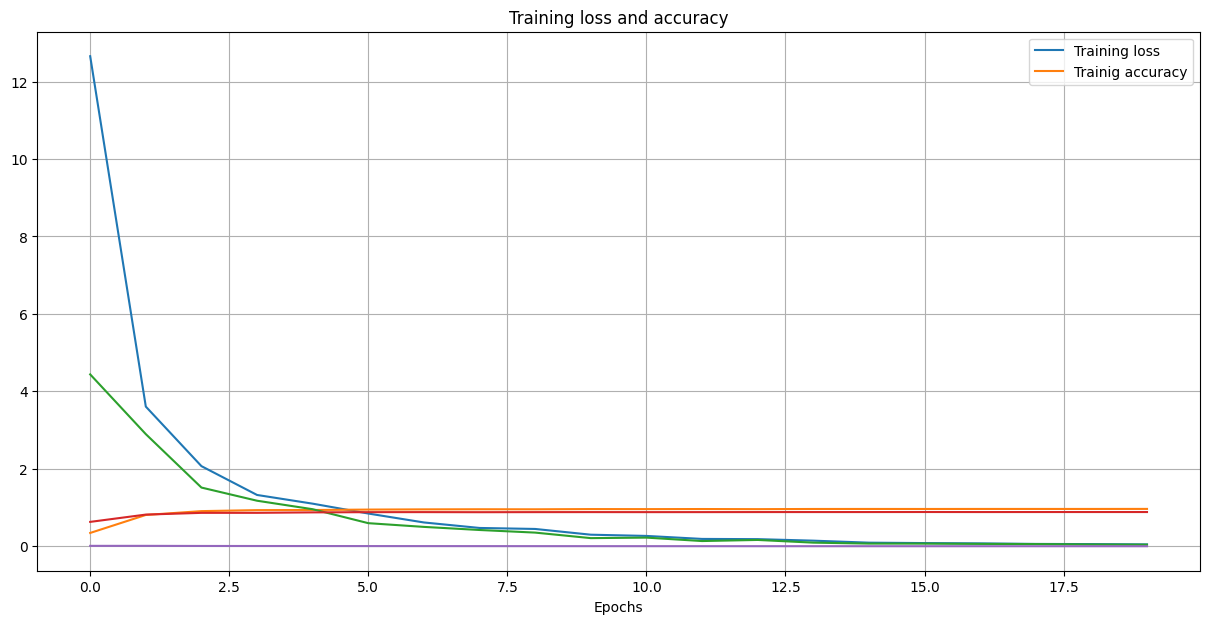

In [78]:
ax = pd.DataFrame(data=history.history).plot(figsize=(15, 7))
ax.grid()
_ = ax.set(title="Training loss and accuracy", xlabel="Epochs")
_ = ax.legend(["Training loss", "Trainig accuracy"])

In [79]:
#https://www.architecture-performance.fr/ap_blog/saving-a-tf-keras-model-with-data-normalization/

In [80]:
training_data

<_BatchDataset element_spec=(TensorSpec(shape=(512, 128), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None))>

In [81]:
###########################
### Probando el predict ###
###########################

import tensorflow as tf
import pandas as pd
import numpy as np

# Extract the relevant data
a = val_data.iloc[1:10, 4].tolist()
basic_tok_tensor = tf.convert_to_tensor(a, dtype=tf.int64)
# Make predictions
tf.math.top_k(model.predict(basic_tok_tensor),2)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


TopKV2(values=<tf.Tensor: shape=(9, 2), dtype=float32, numpy=
array([[1.00000000e+00, 2.71840559e-08],
       [9.99999881e-01, 4.11137293e-08],
       [9.99997973e-01, 1.14009094e-06],
       [9.99999285e-01, 4.63350318e-07],
       [9.99999642e-01, 1.09270196e-07],
       [9.99940276e-01, 5.14761414e-05],
       [9.99997735e-01, 1.38194571e-06],
       [9.99993205e-01, 4.45145224e-06],
       [9.99998927e-01, 6.34279615e-07]], dtype=float32)>, indices=<tf.Tensor: shape=(9, 2), dtype=int32, numpy=
array([[173, 304],
       [141, 221],
       [224, 286],
       [ 34, 154],
       [ 22,  33],
       [289, 298],
       [158, 290],
       [205,  97],
       [307, 157]], dtype=int32)>)

In [82]:
#Lo que da la label es la posición que tiene determinada institución en el diccionario.

In [83]:
### Opción 3: con dataset creado para argentina (Santiago)
all_data = pd.read_csv(f'{base_path}V2/testeo_ar.tsv',sep="\t")
all_data['labels'] = all_data['labels'].apply(lambda x: [int(i.strip()) for i in x[1:-1].split(",")])
all_data=all_data.explode('labels')
all_data['labels'] = all_data['labels'].astype(int)
print(all_data.info())
all_data.head(3)
all_data.shape

<class 'pandas.core.frame.DataFrame'>
Index: 1212 entries, 0 to 1211
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   paper_id            1212 non-null   int64 
 1   affiliation_string  1212 non-null   object
 2   labels              1212 non-null   int64 
 3   labels_name         1212 non-null   object
 4   dataset             1212 non-null   object
dtypes: int64(2), object(3)
memory usage: 56.8+ KB
None


(1212, 5)

In [84]:
import unidecode
to_predict=all_data
# Decode text so only ASCII characters are used

import re # Import the 're' module for regular expressions
import pandas as pd

def preprocess_affiliation_text(text):
    # Normalización de caracteres
    # Call the unidecode function within the unidecode module
    text = unidecode.unidecode(text)
    # Convertir a minúsculas
    text = text.lower()
    # Remover caracteres especiales (si es necesario)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Aplicar el preprocesamiento a los datos de entrenamiento, validación y prueba
to_predict['decoded_text'] = to_predict['affiliation_string'] .apply(preprocess_affiliation_text)
print(to_predict.head(2))

decoded_text=to_predict
decoded_text=pd.DataFrame(decoded_text)
print(decoded_text.head(2))

#basic_tokenizer = PreTrainedTokenizerFast(tokenizer_file=os.path.join(model_path, "basic_model_tokenizer"))
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, DistilBertTokenizer
from transformers import DataCollatorWithPadding, PreTrainedTokenizerFast
model_path1 = f'{base_path}V2/002_Model/'
basic_tokenizer = PreTrainedTokenizerFast(tokenizer_file=os.path.join(model_path1, "basic_model_tokenizer"))
###
decoded_text['basic_tok_data'] = basic_tokenizer(to_predict['decoded_text'].tolist())['input_ids']
###
decoded_text['basic_tok_data'] = [max_len_and_pad(x) for x in decoded_text['basic_tok_data']]
print(decoded_text['basic_tok_data'].shape)
print(decoded_text.head(2))

# Convert the padded data to a TensorFlow tensor
basic_tok_data=decoded_text['basic_tok_data'].tolist()
basic_tok_tensor = tf.convert_to_tensor(basic_tok_data, dtype=tf.int64)

# Proceed with the rest of your code
all_scores, all_labels = tf.math.top_k(model.predict(basic_tok_tensor),1)  # Use the padded tensor here
all_scores = all_scores.numpy().tolist()
all_labels = all_labels.numpy().tolist()

     paper_id                                 affiliation_string     labels  \
0  4390398210  IFLP, CONICET - Dpto. de Física, Universidad N...  874386039   
1  4391149943                       Universidad Nacional del Sur   56858762   

                                        labels_name    dataset  \
0  ['874386039 - Universidad Nacional de La Plata']  testeo_ar   
1       ['56858762 - Universidad Nacional del Sur']  testeo_ar   

                                        decoded_text  
0  iflp conicet  dpto de fisica universidad nacio...  
1                       universidad nacional del sur  
     paper_id                                 affiliation_string     labels  \
0  4390398210  IFLP, CONICET - Dpto. de Física, Universidad N...  874386039   
1  4391149943                       Universidad Nacional del Sur   56858762   

                                        labels_name    dataset  \
0  ['874386039 - Universidad Nacional de La Plata']  testeo_ar   
1       ['56858762 - Univers

In [85]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, DistilBertTokenizer
from transformers import DataCollatorWithPadding, PreTrainedTokenizerFast
# Import TFSMLayer from tensorflow.keras.layers
from tensorflow.keras.layers import TFSMLayer

basic_model_path=f'{base_path}V2/002_Model/Result_basic_model/basic_model/'
# Instead of using tf.keras.models.load_model, use TFSMLayer to load the SavedModel
basic_model = TFSMLayer(basic_model_path, call_endpoint='serving_default')
#basic_model = tf.keras.models.load_model(os.path.join(model_path, "basic_model"), compile=False)
#basic_model.trainable = False

# Convert the padded data to a TensorFlow tensor
basic_tok_data=decoded_text['basic_tok_data'].tolist()
basic_tok_tensor = tf.convert_to_tensor(basic_tok_data, dtype=tf.int64)

# Cast the tensor to float32
#basic_tok_tensor = tf.cast(basic_tok_tensor, dtype=tf.float32)

# Proceed with the rest of your code
# Get the prediction output from the model
predictions = basic_model(basic_tok_tensor)

# Extract the 'output_0' tensor from the predictions dictionary
model_output = predictions['output_0']

# Apply tf.math.top_k to the extracted tensor
all_scores, all_labels = tf.math.top_k(model_output, 3)  # Use the extracted tensor here
all_scores = all_scores.numpy().tolist()
all_labels = all_labels.numpy().tolist()

print(all_scores)
print(all_labels)

[[0.9566105604171753, 0.029885513707995415, 0.002738814800977707], [0.9991666078567505, 0.0006127621745690703, 0.0001901223586173728], [0.9990807771682739, 0.0009002735023386776, 1.1207514035049826e-05], [0.9571259617805481, 0.029107503592967987, 0.009139537811279297], [0.9992026686668396, 0.0007902372162789106, 3.719273991009686e-06], [0.9808583855628967, 0.01299209427088499, 0.0015491662779822946], [0.9972699284553528, 0.0019318527774885297, 0.00042624236084520817], [0.8219671845436096, 0.14373779296875, 0.012614503502845764], [0.9377721548080444, 0.025671258568763733, 0.012400995008647442], [0.6405475735664368, 0.2877289652824402, 0.035605546087026596], [0.39293769001960754, 0.19928386807441711, 0.10504797101020813], [0.9978100657463074, 0.002071863505989313, 5.35128237970639e-05], [0.8483288884162903, 0.1404174268245697, 0.005096192471683025], [0.9998238682746887, 6.18727644905448e-05, 4.830186298931949e-05], [0.9883650541305542, 0.00902086216956377, 0.0009561877232044935], [0.6488

In [87]:
!pip install colab-convert
!colab-convert /content/drive/MyDrive/openalex-institution-parsing/V2/002_Model/Notebooks/002a_basic_model.ipynb /content/drive/MyDrive/openalex-institution-parsing/V2/002_Model/Notebooks/002a_basic_model.py

  Preparing metadata (setup.py) ... done
  Created wheel for colab-convert: filename=colab_convert-2.0.5-py3-none-any.whl size=19207 sha256=ef36b511afbb828f1a1181fc0f3f11361b00cba10082fd94ff6456ad2dd9d478
  Stored in directory: /root/.cache/pip/wheels/a7/9f/0a/70f4be5eeba4a3fca9d7bcf68d5a4e97edb9f22be449cc1e8c
Successfully built colab-convert

---------------------------
----------[START]----------
---------------------------
[OK]   en_US Detected as a supported Language
[OK]   convert magic commands
[OK]   commenting out unsupported magic commands
[OK]   keeping new imports made by converter
[NOT]  showing outputs from converter

convert /content/drive/MyDrive/openalex-institution-parsing/V2/002_Model/Notebooks/002a_basic_model_0411.ipynb to /content/drive/MyDrive/openalex-institution-parsing/V2/002_Model/Notebooks/002a_basic_model_0411.py
finished
conversion took 0.816085 seconds

log file created:
/content/cc-outputs.log
